In [3]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import os,sys
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import csv
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import accuracy_scoretumne #dekha hai koi
import pandas as pd
from pydrive.auth import GoogleAuth
from tensorflow import keras
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls '/content/gdrive/My Drive/ME'

my_model_1.h5  my_model_2.h5  my_model.h5  PitchLabel_csv  test  Wavfile


In [5]:
def load_audio(file):
    x,sr = librosa.load(file,sr=10000,mono=True)  #merge the audio into a single channel and downsampled to 10KHz
    S = calc_spec(x,sr)
    # print("S.SIZE ",np.shape(S))
    gtv,gtf = get_pitch(file)
    gtf = np.append(gtf,np.zeros(np.shape(S)[1]-len(gtf)))
    # print("gtf ",np.shape(gtf))
    return gtf

def calc_spec(x,sr):
    D = np.abs(librosa.stft(x, n_fft = Nfft, hop_length = hop_size, win_length = win_size, window='hann', dtype = np.complex256))
    D = librosa.power_to_db(D,ref=np.max)
    return D


def get_pitch(file):
    gtf = []
    gtv = []
    pathname = os.path.splitext(file)[0]
    filename = os.path.basename(pathname)
    # ff = pitch_dir + '/' + filename + '.csv'
    ff = pitch_dir + '/' + filename + '.csv'

    with open(ff,'r') as fin:
        reader = csv.reader(fin)
        for row in reader:
            gtv.append(float(row[0]))
            gtf.append(float(row[1]))
    return gtv,gtf    
    
    
def closest(arr, K):  # arr is a vector
    idx = (np.abs(arr - K)).argmin() 
    return idx,arr[idx]

def onehotlabel(pitch_range):
    values = np.asarray(pitch_range)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
#     print(integer_encoded)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def getonehot(y):    
    yhot = np.zeros((len(y),len(pitch_range)))
    for i in range(len(y)):
        idx,val = closest(pitch_range,y[i]) 
#         print(idx,val,y[i])
        yhot[i,:] = onehot_pitch_range[idx,:]
    return yhot


def RPA(v,pred_Melody,pitch_labels,Nt):
    N=0
    D=0
    for i in range(Nt):
        if v[i]==1:
            if pred_Melody[i]!=0:
                N+=v[i]*Thres(M(pred_Melody[i])-M(pitch_labels[i]))
            D+=v[i]
    Raw_pitch_acc=(N/D)*100
    #print("RPA is {} %".format(Raw_pitch_acc))
    return Raw_pitch_acc

def M(f):
    f_ref=100
    return 12*np.log2(f/f_ref)

def Thres(a):
    if -0.5<a and a<0.5:
        t=1
    else:
        t=0
    return t

def Angular(a):
    x=a-12*int(a/12+0.5)
    return x

In [6]:
model_srate = 16000
from numpy.lib.stride_tricks import as_strided
def get_activation(audio, sr, model_capacity='full', center=True, step_size=10,verbose=1):
    if len(audio.shape) == 2:
        audio = audio.mean(1)  # make mono
    audio = audio.astype(np.float32)
    if sr != model_srate:
        # resample audio if necessary
        from resampy import resample
        audio = resample(audio, sr, model_srate)

    # pad so that frames are centered around their timestamps (i.e. first frame
    # is zero centered).
    if center:
        audio = np.pad(audio, 512, mode='constant', constant_values=0)

    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    hop_length = int(model_srate * step_size / 1000)
    n_frames = 1 + int((len(audio) - 1024) / hop_length)
    frames = as_strided(audio, shape=(1024, n_frames),
                        strides=(audio.itemsize, hop_length * audio.itemsize))
    frames = frames.transpose().copy()

    # normalize each frame -- this is expected by the model
    frames -= np.mean(frames, axis=1)[:, np.newaxis]
    frames /= np.std(frames, axis=1)[:, np.newaxis]

    # run prediction and convert the frequency bin weights to Hz
    return frames

In [7]:
audio_dir = '/content/gdrive/My Drive/ME/Wavfile'
audio_files = glob(audio_dir + '/*.wav')
pitch_dir = '/content/gdrive/My Drive/ME/PitchLabel_csv'
print(len(audio_files))

1000


In [8]:
X = []
y = []


Nfft = 1024
win_size = 1024
hop_size = 100

note_res = 1
pitch_range = np.arange(30, 98 + 1.0/note_res, 1.0/note_res)
pitch_range = np.concatenate([np.zeros(1), pitch_range])
print(len(pitch_range))
onehot_pitch_range = onehotlabel(pitch_range)  #one hot encoded values of MIDI numbers from 40 to 95



for i in range(50):#len(audio_files)):
    # print(i)
    gtf = load_audio(audio_files[i])
    print("for gtf size ",np.shape(gtf))
    gtf_midi = [librosa.hz_to_midi(x) if x!=float(0) else float(0) for x in gtf]
    # X.append(S.T)
    print("getonehot(gtf_midi)  ",np.shape(getonehot(gtf_midi)))
    y.append(getonehot(gtf_midi))
#     print(len(X))
# X = np.vstack(X)
y = np.vstack(y)
print(np.shape(X),np.shape(y))


p=[]
for i in range (50):

  # print(i)
  b,c=librosa.load(audio_files[i])
  f=get_activation(b,c)
  # print(f.shape)
  p.append(f)
# z=np.zeros([1,1024])
# np.shape(z)
# p.append(z)
p=np.vstack(p)
np.shape(p)

70
for gtf size  (615,)
getonehot(gtf_midi)   (615, 70)
for gtf size  (881,)
getonehot(gtf_midi)   (881, 70)
for gtf size  (989,)
getonehot(gtf_midi)   (989, 70)
for gtf size  (813,)
getonehot(gtf_midi)   (813, 70)
for gtf size  (708,)
getonehot(gtf_midi)   (708, 70)
for gtf size  (925,)
getonehot(gtf_midi)   (925, 70)
for gtf size  (946,)
getonehot(gtf_midi)   (946, 70)
for gtf size  (628,)
getonehot(gtf_midi)   (628, 70)
for gtf size  (647,)
getonehot(gtf_midi)   (647, 70)
for gtf size  (628,)
getonehot(gtf_midi)   (628, 70)
for gtf size  (637,)
getonehot(gtf_midi)   (637, 70)
for gtf size  (752,)
getonehot(gtf_midi)   (752, 70)
for gtf size  (1085,)
getonehot(gtf_midi)   (1085, 70)
for gtf size  (855,)
getonehot(gtf_midi)   (855, 70)
for gtf size  (1191,)
getonehot(gtf_midi)   (1191, 70)
for gtf size  (1137,)
getonehot(gtf_midi)   (1137, 70)
for gtf size  (1159,)
getonehot(gtf_midi)   (1159, 70)
for gtf size  (637,)
getonehot(gtf_midi)   (637, 70)
for gtf size  (781,)
getonehot(gtf_

(41368, 1024)

In [9]:
from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
from tensorflow.keras.models import Model
layers = [1, 2, 3, 4, 5, 6]
# capacity_multiplier = {'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32}[model_capacity]
filters = [n * 32 for n in [32, 4, 4, 4, 8, 16]]
widths = [512, 64, 64, 64, 64, 64]
strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
a = Input(shape=(1024,), name='input', dtype='float32')
b = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(a)
for l, f, w, s in zip(layers, filters, widths, strides):
  b = Conv2D(f, (w, 1), strides=s, padding='same',
              activation='relu', name="conv%d" % l)(b)
  b = BatchNormalization(name="conv%d-BN" % l)(b)
  b = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                name="conv%d-maxpool" % l)(b)
  b = Dropout(0.25, name="conv%d-dropout" % l)(b)

b = Permute((2, 1, 3), name="transpose")(b)
b = Flatten(name="flatten")(b)
b = Dropout(0.25, name="dropout")(b)

b = Dense(70, activation='softmax', name="classifier")(b)

model = Model(inputs=a, outputs=b)
model.compile('adam', 'categorical_crossentropy','accuracy')
model.summary()
#model.fit()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
input-reshape (Reshape)      (None, 1024, 1, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 1, 1024)      525312    
_________________________________________________________________
conv1-BN (BatchNormalization (None, 256, 1, 1024)      4096      
_________________________________________________________________
conv1-maxpool (MaxPooling2D) (None, 128, 1, 1024)      0         
_________________________________________________________________
conv1-dropout (Dropout)      (None, 128, 1, 1024)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 1, 128)       838873

In [10]:
# # from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
# # from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
# # from tensorflow.keras.models import Model
# # layers = [1, 2, 3, 4, 5, 6]
# # # capacity_multiplier = {'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32}[model_capacity]
# # filters = [n * 32 for n in [32, 4, 4, 4, 8, 16]]
# # widths = [512, 64, 64, 64, 64, 64]
# # strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
# # a = Input(shape=(1024,), name='input', dtype='float32')
# # b = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(a)
# # for l, f, w, s in zip(layers, filters, widths, strides):
# #   b = Conv2D(f, (w, 1), strides=s, padding='same',
# #               activation='relu', name="conv%d" % l)(b)
# #   b = BatchNormalization(name="conv%d-BN" % l)(b)
# #   b = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
# #                 name="conv%d-maxpool" % l)(b)
# #   b = Dropout(0.25, name="conv%d-dropout" % l)(b)

# # b = Permute((2, 1, 3), name="transpose")(b)
# # b = Flatten(name="flatten")(b)
# # b = Dropout(0.25, name="dropout")(b)

# # b = Dense(70, activation='softmax', name="classifier")(b)

# # model = Model(inputs=a, outputs=b)
# # model.compile('adam', 'categorical_crossentropy','accuracy')
# # model.summary()
# # #model.fit()

# from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
# from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
# from tensorflow.keras.models import Model
# layers = [1, 2, 3]
# # capacity_multiplier = {'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32}[model_capacity]
# filters = [n * 32 for n in [32, 4, 2, 4, 8, 16]]
# widths = [512, 64, 64, 64, 64, 64]
# strides = [(4, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
# a = Input(shape=(1024,), name='input', dtype='float32')
# b = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(a)
# for l, f, w, s in zip(layers, filters, widths, strides):
#   conv = Convolution2DFlipout(f, (w, 1), strides=s, padding='same',
#               activation='relu', name="conv%d" % l)
#   conv = add_kl_weight(conv, X_train.shape[0])
#   b = conv(b)
#   b = BatchNormalization(name="conv%d-BN" % l)(b)
#   # b = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
#   #               name="conv%d-maxpool" % l)(b)
#   # b = Dropout(0.25, name="conv%d-dropout" % l)(b)
#   # b = Activation('relu')(b)

# b = Permute((2, 1, 3), name="transpose")(b)
# b = Flatten(name="flatten")(b)
# b = Dropout(0.25, name="dropout")(b)

# dense = DenseFlipout(70, activation='softmax', name="classifier")
# dense = add_kl_weight(dense, X_train.shape[0])
# b = dense(b)

# model = Model(inputs=a, outputs=b)
# # model.compile('adam', 'categorical_crossentropy','accuracy')
# lr =1e-3
# model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
#                    experimental_run_tf_function=False)

# model.summary()
# # model.fit()           47% accuracy

In [11]:
print("p size ",np.shape(p))
X_train, X_test,y_train, y_test = train_test_split(p, y, test_size = 0.2, random_state = 4)
print("X_TRAIN SHAPE ",np.shape(X_train))
print("Y_train SHAPE ",np.shape(y_train))
print("X_test SHAPE ",np.shape(X_test))
print("Y_TEST SHAPE ",np.shape(y_test))


p size  (41368, 1024)
X_TRAIN SHAPE  (33094, 1024)
Y_train SHAPE  (33094, 70)
X_test SHAPE  (8274, 1024)
Y_TEST SHAPE  (8274, 70)


In [12]:
y_train_scalar = np.array([np.where(r==1)[0][0] for r in y_train])
y_test_scalar = np.array([np.where(r==1)[0][0] for r in y_test])

np.shape(y_train_scalar),np.shape(y_test_scalar)

((33094,), (8274,))

In [13]:
batch_size = 128
n_epochs = 20
hist = model.fit(X_train, y_train, batch_size = batch_size, epochs = n_epochs, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/20
259/259 [==============================] - 112s 305ms/step - loss: 2.4080 - accuracy: 0.5395 - val_loss: 1.4330 - val_accuracy: 0.5697
Epoch 2/20
259/259 [==============================] - 77s 299ms/step - loss: 0.9460 - accuracy: 0.7194 - val_loss: 0.8251 - val_accuracy: 0.7567
Epoch 3/20
259/259 [==============================] - 79s 305ms/step - loss: 0.7889 - accuracy: 0.7579 - val_loss: 0.7806 - val_accuracy: 0.7653
Epoch 4/20
259/259 [==============================] - 79s 305ms/step - loss: 0.7190 - accuracy: 0.7681 - val_loss: 3.5907 - val_accuracy: 0.6493
Epoch 5/20
259/259 [==============================] - 79s 305ms/step - loss: 0.7635 - accuracy: 0.7693 - val_loss: 0.6200 - val_accuracy: 0.7964
Epoch 6/20
259/259 [==============================] - 79s 303ms/step - loss: 0.5845 - accuracy: 0.8156 - val_loss: 0.5825 - val_accuracy: 0.8094
Epoch 7/20
259/259 [==============================] - 79s 303ms/step - loss: 0.6093 - accuracy: 0.8133 - val_loss: 0.5610 - val_a

In [14]:
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

# print("Time: {}".format(time.time()-start))

259/259 [==============================] - 8s 29ms/step - loss: 0.5225 - accuracy: 0.8547
[0.5224563479423523, 0.8547256588935852]
Test loss: 0.5224563479423523
Test accuracy: 0.8547256588935852


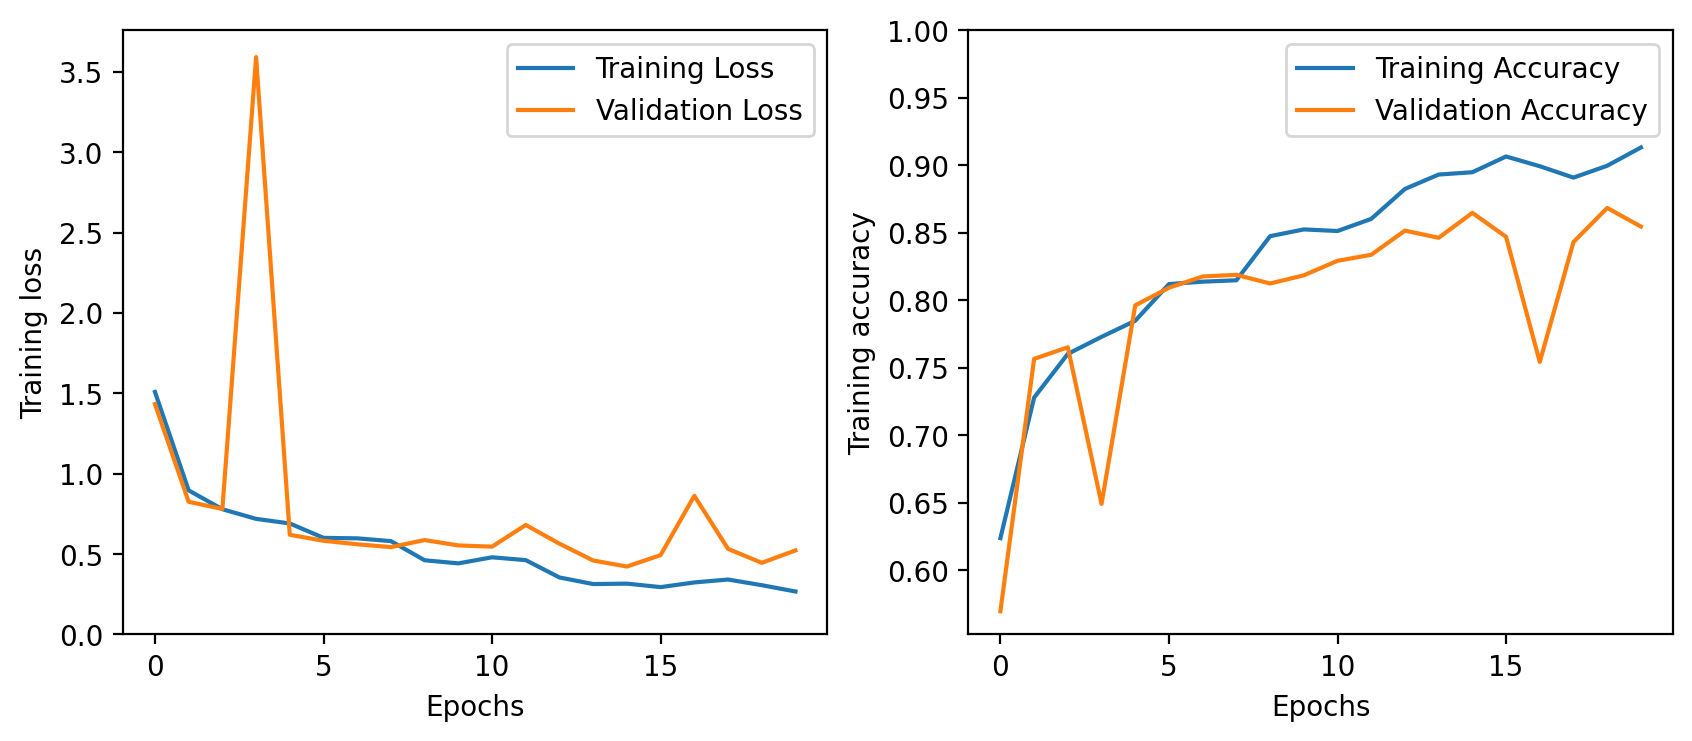

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax[0].plot(range(n_epochs), hist.history['loss'], label='Training Loss')
ax[0].plot(range(n_epochs), hist.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])

ax[1].plot(range(n_epochs), hist.history['accuracy'], label='Training Accuracy')
ax[1].plot(range(n_epochs), hist.history['val_accuracy'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([None, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.show()

In [16]:
# model.save("/content/gdrive/My Drive/ME/my_model.h5")
# import os
# checkpoint_path = "/content/gdrive/My Drive/ME"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# import tensorflow
# # Create a callback that saves the model's weights
# cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
# # os.listdir(checkpoint_dir)

In [17]:
import keras
from keras.datasets import mnist
from keras import backend as K
import numpy as np
from tensorflow.python.keras.backend import eager_learning_phase_scope
# model = tf.keras.models.load_model("/content/gdrive/My Drive/ME/my_model.h5")

def get_gp_mnist_data(model, X):
    """
        Computes the activations of the last layer of a CNN trained on MNIST for the training
        and test data for the MNIST dataset
    """

    # model = keras.models.load_model(model_file)
    # partial_model = model(model.inputs, model.layers[1].output)

    # return partial_model
    # intermediate_layer_model = keras.Model(inputs=model.input,
    #                                    outputs=model.layers[-2].output)
    # intermediate_output = intermediate_layer_model(X)

    # return intermediate_output
    return _get_ith_layer_output(model, X, -2)

# def get_ith_layer_output(model, X, i, mode='test'):
#     ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
#     get_ith_layer = keras.backend.function(
#         [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
#     layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
#     return layer_output

def _get_ith_layer_output(model, X, i, mode='test', batch_size= 64):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
#    get_ith_layer = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()],[model.layers[i].output])
#    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
#    return layer_output
  
    # get_ith_layer = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()],[model.layers[i].output])
    get_ith_layer = K.function([model.input], [model.layers[i].output])

    layer_output = []
    batch_start = 0
    while batch_start < len(X):
        outputs = get_ith_layer([X[batch_start:batch_start+batch_size]])[0]
        layer_output.append(outputs)
        batch_start += batch_size
    layer_output = np.concatenate(layer_output)
    return layer_output

In [18]:
# x_train = get_gp_mnist_data("/content/gdrive/My Drive/ME/my_model.h5", X_train)
# x_test = get_gp_mnist_data("/content/gdrive/My Drive/ME/my_model.h5", X_test)
x_train = get_gp_mnist_data(model, X_train)
x_test = get_gp_mnist_data(model, X_test)


In [19]:
print(np.shape(x_train),np.shape(x_test))
print(np.shape(y_train_scalar),np.shape(y_test_scalar))
print(np.shape(y_train),np.shape(y_test))

(33094, 2048) (8274, 2048)
(33094,) (8274,)
(33094, 70) (8274, 70)


In [20]:
!pip install gpflow
import gpflow
import tensorflow as tf

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt


     |████████████████████████████████| 276kB 6.4MB/s 


In [21]:
num_classes = 70
num_features = 2048

import numpy as np
import scipy.io

from keras.utils import to_categorical
from keras import backend as K

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
import numpy as np
import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt

%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter


# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)


In [22]:
  # %%timeit
x_train_1 = x_train.astype('float64').reshape(-1,num_features)[:500]
print(np.shape(x_train_1))
y_train_1 = y_train_scalar.astype('float64').reshape(-1,1)[:500]
print(np.shape(y_train_1))

(500, 2048)
(500, 1)


In [23]:

# kernel = gpflow.kernels.Matern32(num_features) + gpflow.kernels.White(num_features, 0.01)
kernel = gpflow.kernels.Matern52(num_features) + gpflow.kernels.White(variance=0.1)


likelihood = gpflow.likelihoods.MultiClass(num_classes)
Z=x_train_1[::5].copy()
print(np.shape(Z))
num_latent=num_classes
whiten=True
q_diag=True
data = (x_train_1, y_train_1)
m = gpflow.models.SVGP(kernel=kernel, 
                       likelihood=likelihood,
                       inducing_variable=Z, 
                       num_latent_gps=num_latent,
                       whiten=whiten, 
                       q_diag=q_diag)

set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")



(100, 2048)


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2048.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.10000000000000002
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 2048)",float64,"[[-0.09897513, 0.85579443, -0.23080674..."
SVGP.q_mu,Parameter,Identity,,True,"(100, 70)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(100, 70)",float64,"[[1., 1., 1...."


In [24]:
opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(
    m.training_loss_closure(data), m.trainable_variables, options=dict(maxiter=ci_niter(300))
)
print_summary(m, fmt="notebook")


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2048.019437127956
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,86.20813402897203
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.10000000000000002
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 2048)",float64,"[[-0.09897513, 0.85579443, -0.23080674..."
SVGP.q_mu,Parameter,Identity,,True,"(100, 70)",float64,"[[1.69558061e+00, -4.45471074e-01, -4.45471074e-01..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(100, 70)",float64,"[[0.01162098, 0.48264053, 0.48264053..."


In [32]:
x_test_1 = x_test.astype('float64').reshape(-1,num_features)
print(x_test_1.shape)
p, var = m.predict_y(x_test_1)
print(p)
print("p shape ===================================================== ",np.shape(p))

print(var)

(8274, 2048)
tf.Tensor(
[[2.20747935e-01 6.31480395e-05 6.31480395e-05 ... 6.31480395e-05
  6.31480395e-05 6.31480395e-05]
 [9.98903516e-01 1.49586949e-05 1.49586949e-05 ... 1.49586949e-05
  1.49586949e-05 1.49586949e-05]
 [9.92527543e-01 1.62806892e-05 1.62806892e-05 ... 1.62806892e-05
  1.62806892e-05 1.62806892e-05]
 ...
 [1.76978920e-01 3.85230091e-05 3.85230091e-05 ... 3.85230091e-05
  3.85230091e-05 3.85230091e-05]
 [2.27345212e-01 8.27224816e-05 8.27224816e-05 ... 8.27224816e-05
  8.27224816e-05 8.27224816e-05]
 [9.90847238e-01 1.88751930e-05 1.88751930e-05 ... 1.88751930e-05
  1.88751930e-05 1.88751930e-05]], shape=(8274, 70), dtype=float64)
p shape =====================================================  (8274, 70)
tf.Tensor(
[[1.72018284e-01 6.31440518e-05 6.31440518e-05 ... 6.31440518e-05
  6.31440518e-05 6.31440518e-05]
 [1.09528210e-03 1.49584711e-05 1.49584711e-05 ... 1.49584711e-05
  1.49584711e-05 1.49584711e-05]
 [7.41661901e-03 1.62804241e-05 1.62804241e-05 ... 1.628042

In [34]:
predictions = np.argmax(p, axis=-1)
print("predictions ",predictions)

print("y_test shape ",np.shape(y_test_scalar))
print("predictions shape ",np.shape(predictions))
accuracy = len(np.argwhere(predictions == y_test_scalar))/len(predictions)
print(accuracy)
print(np.shape(predictions))
print(np.shape(y_test))
print(classification_report(y_test_scalar, predictions))

predictions  [26  0  0 ... 32 23  0]
y_test shape  (8274,)
predictions shape  (8274,)
0.827894609620498
(8274,)
(8274, 70)
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      2479
          12       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         9
          20       0.00      0.00      0.00        19
          21       0.00      0.00      0.00        64
          22       0.00      0.00      0.00        58
          23       0.34      0.90      0.50        94
          24       0.95      0.50      0.65       115
          25       0.81      0.69      0.75       241
          26       0.85      0.79      0.82       309
          27       0.77      0.80      0.79       292
          28       0.84      0.81      0.82       304
          29       0.86      0.74      0.80       376
          30

In [35]:
incorrect_indices = np.argwhere(predictions != y_test_scalar)
correct_indices = np.argwhere(predictions == y_test_scalar)
print(len(incorrect_indices))

1424


p62  [5.91871058e-04 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62818976e-05 9.85081504e-05 9.83014686e-05 5.52204346e-04
 2.18257548e-03 3.26002072e-04 4.89991441e-05 9.22411816e-03
 3.57497877e-03 2.95742023e-02 8.05460952e-01 1.20066860e-01
 7.65314229e-03 2.67685919e-05 4.28882828e-05 1.53022118e-04
 3.78524418e-03 1.02059968e-04 1.96699239e-04 5.89345545e-03
 1.24254718e-03 9.62037454e-05 9.65718264e-05 9.67169634e-05
 5.59731323e-03 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.62037454e-05 9.62037454e-05 9.62037454e-05
 9.62037454e-05 9.6

<Figure size 432x288 with 0 Axes>

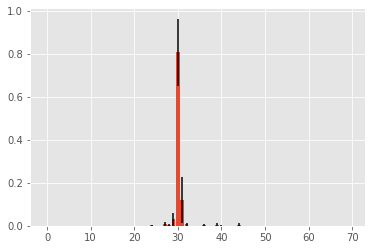

<Figure size 432x288 with 0 Axes>

In [38]:
%matplotlib inline
index = incorrect_indices[5]
# print(var, index)
print("p62 " ,p[62].numpy().squeeze())
print("var62 " ,var[62].numpy().squeeze())
plt.bar(np.arange(70), p[62].numpy().squeeze(), yerr=var[62].numpy().squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
# plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest")


2
[9.92527543e-01 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62807608e-05 1.63545393e-05 1.63362584e-05 1.44979105e-05
 1.45604520e-05 1.45847758e-05 1.44930372e-05 4.49441762e-05
 1.44927883e-05 5.53372311e-05 5.58741840e-03 1.93665188e-05
 1.88417120e-05 1.45051222e-05 1.44929890e-05 1.45018347e-05
 1.45595847e-05 1.49858630e-05 1.44933512e-05 3.72017058e-05
 1.45208558e-05 1.62806892e-05 1.62899246e-05 1.62982675e-05
 6.69591688e-04 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.62806892e-05 1.62806892e-05 1.62806892e-05
 1.62806892e-05 1.6280

<Figure size 432x288 with 0 Axes>

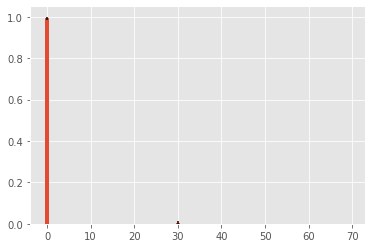

<Figure size 432x288 with 0 Axes>

In [40]:
# %matplotlib inline
index = correct_indices[2].squeeze()
print(index)
print(p[index].numpy().squeeze())
print(var[index].numpy().squeeze())
plt.bar(np.arange(70), p[index].numpy().squeeze(), yerr=var[index].numpy().squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
# plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest")


In [28]:
test_audio_dir = '/content/gdrive/My Drive/ME/test/Wavfile'
test_audio_files = glob(test_audio_dir + '/*.wav')
test_pitch_dir = '/content/gdrive/My Drive/ME/test/PitchLabel'
print(len(test_audio_files))

10


In [29]:
def get_testpitch(file):
    pathname = os.path.splitext(file)[0]
    filename = os.path.basename(pathname)
    file = test_pitch_dir + '/' + filename + '.csv'
    df = pd.read_csv(file)

    gtv,gtf = df['0.01'],df['0']
    # gtv,gtf = np.loadtxt(file)[:,0],np.loadtxt(file)[:,1]
    return gtv,gtf



def predict_pitch(ypred):
#     y_pred = np.zeros((np.shape(ypred)[0],np.shape(ypred)[1]))
    pred_y = []
    for i in range(np.shape(ypred)[0]):
        indx = np.argmax(ypred[i])
#         y_pred[i,indx]=1
        pred_y.append(pitch_range[indx])    
    return pred_y

In [30]:
for i in range(len(test_audio_files)):  
    print(test_audio_files[i])
    y,sr = librosa.load(test_audio_files[i],sr=10000)
    # S = calc_spec(y,sr)
    # print(S.shape)
    s1=get_activation(y,sr)
    print(s1.shape)
    
    gtv,y_true = get_testpitch(test_audio_files[i])
    s1 = s1[:,:len(y_true)]
    # print(s1.shape)
    Nf,Nt = np.shape(s1)
    ypred = model.predict(s1)
    y_pred = librosa.midi_to_hz(predict_pitch(ypred))
   
    v = [1 if i>0 else 0 for i in y_true]
    rpa = RPA(v,y_true,y_pred,Nt)
#     print(y_true,y_pred)
    print('RPA : ',rpa)

/content/gdrive/My Drive/ME/test/Wavfile/train10.wav
(3901, 1024)
RPA :  74.0
/content/gdrive/My Drive/ME/test/Wavfile/train01.wav
(2450, 1024)
RPA :  44.84924623115578
/content/gdrive/My Drive/ME/test/Wavfile/train09.wav
(3201, 1024)
RPA :  34.67153284671533
/content/gdrive/My Drive/ME/test/Wavfile/train07.wav
(2576, 1024)
RPA :  57.12166172106825
/content/gdrive/My Drive/ME/test/Wavfile/train03.wav
(2733, 1024)
RPA :  14.071038251366119
/content/gdrive/My Drive/ME/test/Wavfile/train08.wav
(3143, 1024)
RPA :  44.39252336448598
/content/gdrive/My Drive/ME/test/Wavfile/train05.wav
(3485, 1024)
RPA :  39.325842696629216
/content/gdrive/My Drive/ME/test/Wavfile/train02.wav
(3252, 1024)
RPA :  49.93006993006993
/content/gdrive/My Drive/ME/test/Wavfile/train04.wav
(3353, 1024)
RPA :  15.988372093023257
/content/gdrive/My Drive/ME/test/Wavfile/train06.wav
(2401, 1024)
RPA :  20.423892100192678


In [31]:
p=[]
for i in range (50):

SyntaxError: ignored